<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Demand-simulation" data-toc-modified-id="Demand-simulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Demand simulation</a></span><ul class="toc-item"><li><span><a href="#expected-rewards" data-toc-modified-id="expected-rewards-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>expected rewards</a></span></li><li><span><a href="#sample-draws" data-toc-modified-id="sample-draws-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>sample draws</a></span></li><li><span><a href="#Regression-models-for-demand" data-toc-modified-id="Regression-models-for-demand-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Regression models for demand</a></span></li></ul></li><li><span><a href="#Online-regression" data-toc-modified-id="Online-regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Online regression</a></span><ul class="toc-item"><li><span><a href="#Parametrizations" data-toc-modified-id="Parametrizations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Parametrizations</a></span></li></ul></li><li><span><a href="#Demand-simulation-from-avocado-dataset" data-toc-modified-id="Demand-simulation-from-avocado-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Demand simulation from avocado dataset</a></span><ul class="toc-item"><li><span><a href="#train-model" data-toc-modified-id="train-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>train model</a></span></li><li><span><a href="#simulate-model" data-toc-modified-id="simulate-model-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>simulate model</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

in this notebook:
- demand simulation
- online algorithms demonstration

In [1]:
%load_ext autoreload
%autoreload 2

# add modules from parent package
import sys
sys.path.append('..')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
import scipy.stats as ss
from bandits.online_models import ConstantModel, SimpleLinearRegressor

## Demand simulation

### expected rewards

In [4]:
p_min = 1
p_max = 10
K = 10
dist_mean = 5
dist_std = 2  # note: I increased it to 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

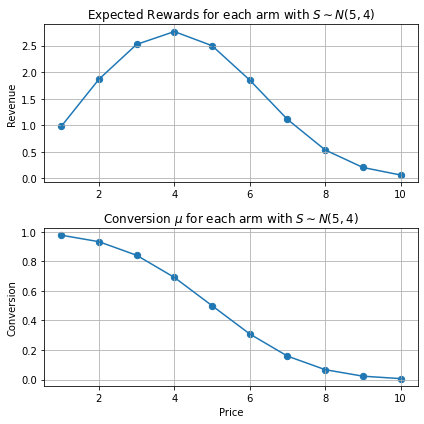

In [5]:
fig,axs=plt.subplots(figsize=(6, 6))

plt.subplot(2, 1, 1)
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)
rewards = arms*mus
plt.plot(arms, rewards)
plt.scatter(arms, rewards, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Revenue')
plt.title('Expected Rewards for each arm with $S \sim N(5, 4)$');

plt.subplot(2, 1, 2)
plt.plot(arms, mus)
plt.scatter(arms, mus, s=40)
# plt.xticks(arms)
plt.grid()
plt.ylabel('Conversion')
plt.xlabel('Price')
plt.title('Conversion $\mu$ for each arm with $S \sim N(5, 4)$')
fig.tight_layout();

### sample draws

In [6]:
p_min = 1
p_max = 10
K = 10
dist_mean = 5
dist_std = 15  # note: I increased it to 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [7]:
n_customers = 100
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)

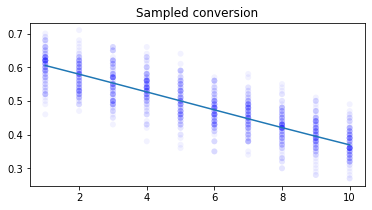

In [8]:
np.random.seed(1)

fig,axs=plt.subplots(figsize=(6, 3))

n_draws_per_arm = 100
for i, mu in enumerate(mus):
    draws = np.random.binomial(n_customers, mu, size=(n_draws_per_arm,))/n_customers
    sns.scatterplot(
        x=np.repeat(arms[i], n_draws_per_arm), y=draws,
        color='blue', edgecolor="none", alpha=0.05);
    
plt.plot(arms, mus)
plt.title('Sampled conversion');

### Regression models for demand

In [9]:
# note that i do not aggregate the result
def smooth_mape(y, y_pred, s=0.1):
    return np.abs(y-y_pred)/(y+s)

def rmse(y, y_pred, s=0.1):
    return np.sqrt(np.mean((y-y_pred)**2))

In [10]:
p_min = 1
p_max = 10
K = 10
dist_mean = 3
dist_std = 6
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [11]:
n_customers = 20
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)

In [12]:
# build the dataset
np.random.seed(1)
n_draws_per_arm = 100
conversion_df = []
for i, mu in enumerate(mus):
    draws = np.random.binomial(n_customers, mu, size=(n_draws_per_arm,))/n_customers
    conversion_df.append(draws)

conversion_df = pd.DataFrame(
    np.vstack([np.repeat(arms, n_draws_per_arm), np.hstack(conversion_df)]).T,
    columns=['price', 'conversion']
)
conversion_df = conversion_df.sample(frac=1).reset_index(drop=True) # shuffle
conversion_df['is_train'] = (conversion_df.index < 0.66*len(conversion_df.index)).astype(int)

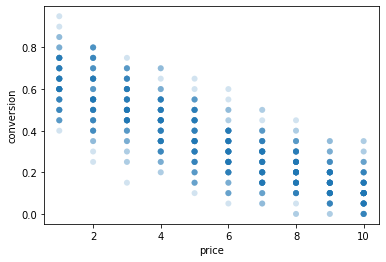

In [13]:
sns.scatterplot(x='price', y='conversion', data=conversion_df, edgecolor='none', alpha=0.2);

In [14]:
train_df = conversion_df[conversion_df['is_train']==1]
val_df = conversion_df[conversion_df['is_train']==0]

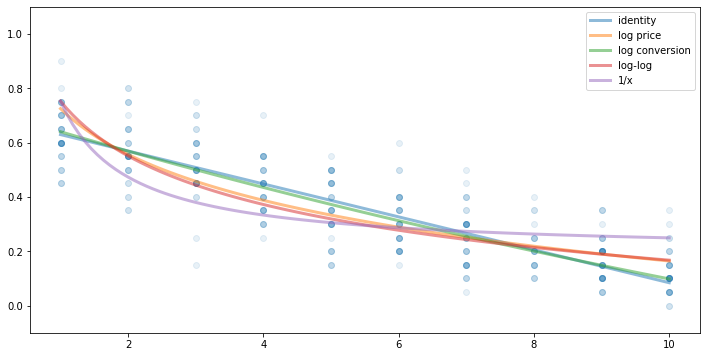

In [15]:
fig,axs=plt.subplots(figsize=(12, 6))

lr_models = [
    ("identity", SimpleLinearRegressor(0, 0)),
    ("log price", SimpleLinearRegressor(0, 0, x_transform=np.log)),
    ("log conversion", SimpleLinearRegressor(0, 0, y_transform=np.log1p, y_inv_transform=np.expm1)),
    ("log-log", SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1)),
    ("1/x", SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x)),
]
scores_df = []

for model_name, model in lr_models:
    x = train_df['price']
    y = train_df['conversion']
    model.update_estimates(x, y)
    x_range = np.linspace(x.min(), x.max(), 100)
    y_hat = model.predict(x_range)
    
    plt.plot(x_range, y_hat, label=model_name, lw=3, alpha=0.5)
    plt.legend();
    
    x = val_df['price']
    y = val_df['conversion']
    y_pred = model.predict(x)
    score = rmse(y, y_pred)
    scores_df.append(score)
    
plt.scatter(x, y, alpha=0.1, label='observations')
plt.ylim(-0.1, 1.1);

In [16]:
scores_df = pd.DataFrame([scores_df], columns=[m for m,_ in lr_models], index=['RMSE'])
scores_df

,identity,log price,log conversion,log-log,1/x
RMSE,0.103029,0.109464,0.101904,0.114617,0.135895


here, the log conversion model, $\textit{Q}=e^{a+b \cdot P}$, was the best

lets see a different example:

In [17]:
p_min = 1
p_max = 10
K = 10
dist_mean = 8
dist_std = 10
dist = ss.norm(loc=dist_mean, scale=dist_std)

In [18]:
n_customers = 40
arms = np.linspace(p_min, p_max, K)
mus = 1-dist.cdf(arms)

In [19]:
# build the dataset
np.random.seed(1)
n_draws_per_arm = 100
conversion_df = []
for i, mu in enumerate(mus):
    draws = np.random.binomial(n_customers, mu, size=(n_draws_per_arm,))/n_customers
    conversion_df.append(draws)

conversion_df = pd.DataFrame(
    np.vstack([np.repeat(arms, n_draws_per_arm), np.hstack(conversion_df)]).T,
    columns=['price', 'conversion']
)
conversion_df = conversion_df.sample(frac=1).reset_index(drop=True) # shuffle
conversion_df['is_train'] = (conversion_df.index < 0.66*len(conversion_df.index)).astype(int)

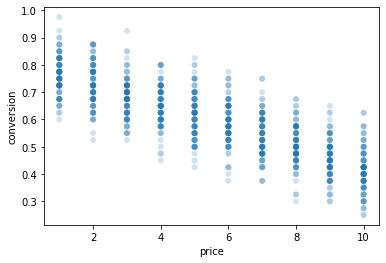

In [20]:
sns.scatterplot(x='price', y='conversion', data=conversion_df, edgecolor='none', alpha=0.2);

In [21]:
train_df = conversion_df[conversion_df['is_train']==1]
val_df = conversion_df[conversion_df['is_train']==0]

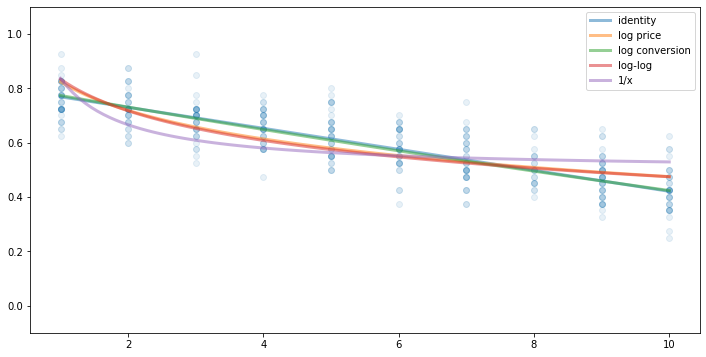

In [22]:
fig,axs=plt.subplots(figsize=(12, 6))

lr_models = [
    ("identity", SimpleLinearRegressor(0, 0)),
    ("log price", SimpleLinearRegressor(0, 0, x_transform=np.log)),
    ("log conversion", SimpleLinearRegressor(0, 0, y_transform=np.log1p, y_inv_transform=np.expm1)),
    ("log-log", SimpleLinearRegressor(0, 0, x_transform=np.log, y_transform=np.log1p, y_inv_transform=np.expm1)),
    ("1/x", SimpleLinearRegressor(0, 0, x_transform=lambda x: 1/x)),
]
scores_df = []

for model_name, model in lr_models:
    x = train_df['price']
    y = train_df['conversion']
    model.update_estimates(x, y)
    x_range = np.linspace(x.min(), x.max(), 100)
    y_hat = model.predict(x_range)
    
    plt.plot(x_range, y_hat, label=model_name, lw=3, alpha=0.5)
    plt.legend();
    
    x = val_df['price']
    y = val_df['conversion']
    y_pred = model.predict(x)
    score = rmse(y, y_pred)
    scores_df.append(score)
    
plt.scatter(x, y, alpha=0.1, label='observations')
plt.ylim(-0.1, 1.1);

In [23]:
scores_df = pd.DataFrame([scores_df], columns=[m for m,_ in lr_models], index=['RMSE'])
scores_df

,identity,log price,log conversion,log-log,1/x
RMSE,0.076009,0.084066,0.07635,0.085934,0.100242


here the identity parametrization ($Q=aP+b$) is the best

## Online regression

In [24]:
%matplotlib notebook

In [25]:
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

<IPython.core.display.Javascript object>


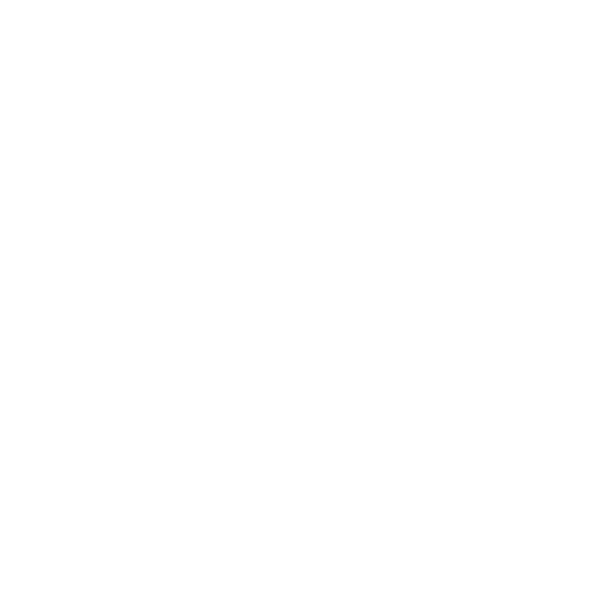

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_xlim(-0.3, 10.3)
ax.set_ylim(-0.1, 1.1)
scatter, = ax.plot([], [], 'bo', label='observation', alpha=0.1)
line, = ax.plot([], [], 'r', label='Linear Regression')
ax.legend()
plt.title('Online linear regression')
plt.xlabel('x')
plt.ylabel('y')


x_data = []
y_data = []
model = SimpleLinearRegressor(0, 0)
x = conversion_df['price']
y = conversion_df['conversion']

def animate(frame_num):
    x_data.append(x[frame_num])
    y_data.append(y[frame_num])
    x_train = np.array(x_data)
    y_train = np.array(y_data)
    
    model.update_estimates(np.array([x[frame_num]]), np.array([y[frame_num]]))
    x_range = np.linspace(x.min(), x.max(), 100)
    y_hat = model.predict(x_range)
    
#     plt.plot(x_range, y_hat, lw=1, alpha=0.5)

    scatter.set_data((x_data, y_data))
    line.set_data((x_range, y_hat))

anim = FuncAnimation(fig, animate, frames=50, interval=10, repeat=True, blit=True)
writer = PillowWriter(fps=5)  
anim.save(f"../images/online_lr.gif", writer=writer) 
plt.show()

In [27]:
%matplotlib inline

### Parametrizations

In this subsection, different regression parametrizations are shown

In [28]:
T = 2500

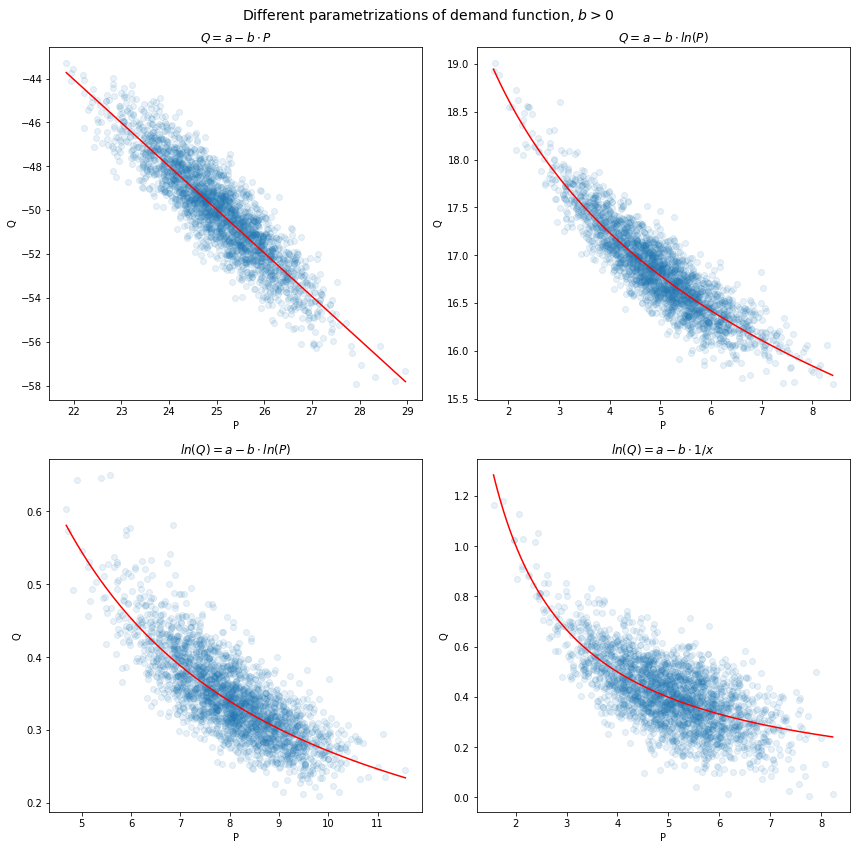

In [29]:
fig,axs=plt.subplots(figsize=(12, 12))

fig.suptitle('Different parametrizations of demand function, $b>0$', fontsize=14)

plt.subplot(2, 2, 1)
np.random.seed(1)
x = np.random.normal(size=(T,), loc=25, scale=1)
y = -2 * x  + np.random.normal(size=(T,), loc=0, scale=1)
slr = SimpleLinearRegressor()
slr.update_estimates(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')
plt.xlabel('P')
plt.ylabel('Q')
plt.title('$Q=a-b \cdot P$');

plt.subplot(2, 2, 2)
x = np.random.normal(size=(T,), loc=5, scale=1)
y = 20-np.log(x) * 2 + np.random.normal(size=(T,), loc=0, scale=0.2)
slr = SimpleLinearRegressor(x_transform=np.log)
slr.update_estimates(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')
plt.xlabel('P')
plt.ylabel('Q')
plt.title('$Q=a-b \cdot ln(P)$');

plt.subplot(2, 2, 3)
x = np.random.normal(size=(T,), loc=8, scale=1)
y = np.exp(1-1*np.log(x) + np.random.normal(size=(T,), loc=0, scale=0.1))
slr = SimpleLinearRegressor(x_transform=np.log, y_transform=np.log, y_inv_transform=np.exp)
slr.update_estimates(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')
plt.xlabel('P')
plt.ylabel('Q')
plt.title('$ln(Q)=a-b \cdot ln(P)$');

plt.subplot(2, 2, 4)
x = np.random.normal(size=(T,), loc=5, scale=1)
y = 2 * 1/(x) + np.random.normal(size=(T,), loc=0, scale=0.1)
slr = SimpleLinearRegressor(x_transform=lambda x: 1/x)
slr.update_estimates(x, y)
x_range = np.linspace(x.min(), x.max(), 100)
y_hat = slr.predict(x_range)
plt.scatter(x, y, alpha=0.1);
plt.plot(x_range, y_hat, color='red')
plt.xlabel('P')
plt.ylabel('Q')
plt.title('$ln(Q)=a-b \cdot 1/x$');

fig.tight_layout();

## Demand simulation from avocado dataset

In [30]:
import os
import warnings

import lightgbm as lgb
import optuna
from optuna.visualization import plot_slice
from optuna.visualization import plot_contour
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

def mape(y, y_pred):
    return np.mean(np.abs(y-y_pred)/y)

mape_scorer = make_scorer(mape, greater_is_better=False)

In [31]:
base_dir = '../data/avocado/'
os.listdir(base_dir)

['avocado.csv', 'avocado-prices.zip']

### train model

In [32]:
avocado_path = os.path.join(base_dir, 'avocado.csv')
df = pd.read_csv(avocado_path)
df = df.drop(columns=['Unnamed: 0'])
df['date'] = df['Date'].astype('datetime64[ns]')
df = df.sort_values('Date')
df = df[df['date'] < '2018-01-01']
df = df[df['type'] == 'conventional'].reset_index(drop=True)

df['price'] = df['AveragePrice']
df['quantity'] = df['Total Volume']

cols = ['date', 'price', 'quantity', 'region']
df = df[cols].copy()

aggregated_regions = [
    'TotalUS', 'West', 'SouthCentral', 'Northeast', 'Southeast', 'Midsouth', 'Plains', 'GreatLakes', 'California'
]
df = df[~df.region.isin(aggregated_regions)]
region_to_volume = df.groupby(['region']).quantity.sum().sort_values(ascending=False).reset_index()
good_regions = set(region_to_volume[:20].region) - set(['LosAngeles'])

In [33]:
def featurize(df):
    df['year-month'] = df['date'].dt.year*100 + df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

In [34]:
featurize(df)

In [35]:
train_df = df[df['date'] < '2017-01-01'].copy()
val_df = df[df['date'] >= '2017-01-01'].copy()

train_df = train_df[train_df.region.isin(good_regions)]
val_df = val_df[val_df.region.isin(good_regions)]

In [36]:
not_for_train_cols = ['date']
target_col = 'quantity'

drop_cols = set(train_df.columns) & set(not_for_train_cols + [target_col])

monotone_constraints_cols = {'price': -1}
monotone_constraints = [
    monotone_constraints_cols[c]
    if monotone_constraints_cols.get(c) is not None else 0 for c in train_df.drop(columns=drop_cols).columns
]

categorical_columns = [
    'month', 'region'
]

def cols_to_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')

In [37]:
cols_to_categorical(train_df, categorical_columns)
cols_to_categorical(val_df, categorical_columns)

In [38]:
params = {
    'objective': 'regression',  # TODO: tweedie
    'boosting': 'gbdt',
    'num_iterations': 100,
    'seed': 123,
    'deterministic': True,

    'metric': 'mape',

    'bagging_seed': 3,
    'feature_fraction_seed': 2,
    'first_metric_only': True,
    'min_gain_to_split': 0,

    # categorical
    'cat_l2': 10,
    'cat_smooth': 10,
    'max_cat_to_onehot': 4,

    'verbose': -1,
    'device': 'cpu',

    'max_depth': 3,
    'bagging_freq': 3,

    'monotone_constraints': monotone_constraints,
    'monotone_constraints_method': 'advanced',
    
    'max_bin': 49,
    'learning_rate': 0.25074154758540007,
    'lambda_l1': 0.030964371012089185,
    'lambda_l2': 0.07513204715139357,
    'num_leaves': 133,
    'feature_fraction': 0.3695536861559177,
    'bagging_fraction': 0.6794620771897983
}

In [39]:
train_data = lgb.Dataset(
    train_df.drop(columns=drop_cols), label=train_df[target_col],
#     categorical_feature=categorical_columns,
)
val_data = lgb.Dataset(
    val_df.drop(columns=drop_cols), label=val_df[target_col],
#     categorical_feature=categorical_columns,
    reference=train_data,
)
model_cols = val_df.drop(columns=drop_cols).columns

In [40]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    model = lgb.train(
        params=params,
        train_set=train_data,
#         valid_sets=[val_data],
        categorical_feature=categorical_columns,
    )

In [41]:
y_pred = model.predict(val_df.drop(columns=drop_cols))

In [42]:
mape(y=val_df[target_col], y_pred=y_pred)

0.10137605967816815

### simulate model

obtain rewards for some regions

In [43]:
date = pd.to_datetime('2017-06-01')
region = 'DallasFtWorth'

mm_prices = df[df.region == region].price.apply(['min','max'])
prices = np.linspace(mm_prices['min'], mm_prices['max'], 25)

In [44]:
elasticity_df = pd.DataFrame(np.array([prices]).T, columns=['price'])
elasticity_df['date'] = date
elasticity_df['region'] = region
featurize(elasticity_df)
cols_to_categorical(elasticity_df, categorical_columns)

In [45]:
elasticity_df['quantity'] = model.predict(elasticity_df.drop(columns=['date']))

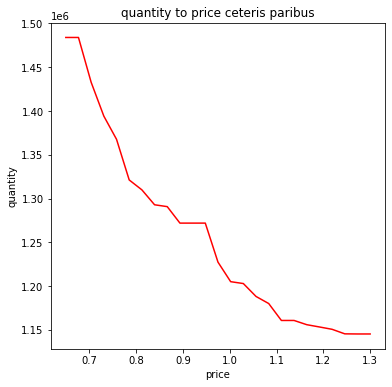

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.lineplot(x='price', y='quantity', data=elasticity_df, color='red')
plt.title('quantity to price ceteris paribus');

lets simulate the demand for a year

we will pick price at random

we will also add noise with std estimated from past volume

In [47]:
start_date = pd.to_datetime('2017-01-01')
T = 360
K = 10
end_date = start_date + pd.Timedelta(T-1, unit='D')

date_range = pd.date_range(start=start_date, end=end_date, freq='D')
mm_prices = df[df.region == region].price.apply(['min','max'])
prices = np.linspace(mm_prices['min'], mm_prices['max'], K)

q_std = df[df.region == region].quantity.std()

In [48]:
np.random.seed(1)
sampled_prices = np.random.choice(prices, size=T)
e = np.random.normal(loc=0, scale=q_std, size=T)

In [49]:
predict_df = pd.DataFrame([sampled_prices], index=['price']).T
predict_df['date'] = date_range
predict_df['region'] = region
featurize(predict_df)
cols_to_categorical(predict_df, categorical_columns)
predict_df['quantity_without_noise'] = model.predict(predict_df[model_cols])
predict_df['quantity'] = predict_df['quantity_without_noise'] + e
predict_df.head()

,price,date,region,year-month,year,month,quantity_without_noise,quantity
0,1.011111,2017-01-01,DallasFtWorth,201701,2017,1,1.034693e+06,1.050933e+06
1,1.227778,2017-01-02,DallasFtWorth,201701,2017,1,9.772376e+05,1.237624e+06
2,1.300000,2017-01-03,DallasFtWorth,201701,2017,1,9.770969e+05,1.172009e+06
3,1.011111,2017-01-04,DallasFtWorth,201701,2017,1,1.034693e+06,1.056746e+06
4,0.650000,2017-01-05,DallasFtWorth,201701,2017,1,1.315774e+06,1.303438e+06


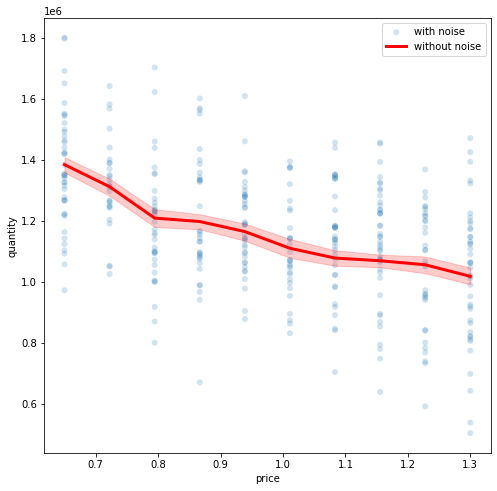

In [50]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='price', y='quantity', data=predict_df, edgecolor='none', alpha=0.2, label='with noise')
sns.lineplot(x='price', y='quantity_without_noise', data=predict_df, color='red', lw=3, label='without noise');

we also need to normalize it so that max(quantity)=1

In [51]:
quantity_norm = df[df.region == region].quantity.max()
predict_df['quantity_norm'] = predict_df['quantity'] / quantity_norm
predict_df['quantity_norm'] = predict_df['quantity_without_noise'] / quantity_norm

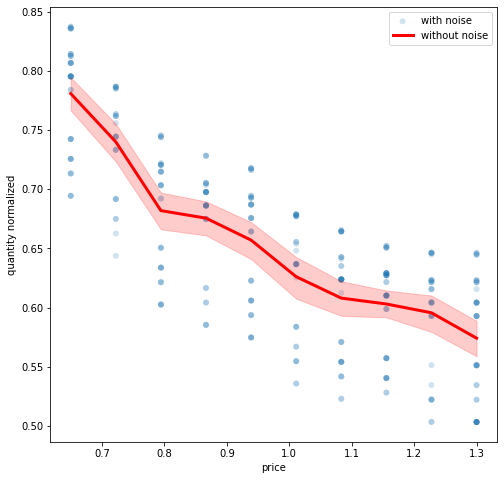

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='price', y='quantity_norm', data=predict_df, edgecolor='none', alpha=0.2, label='with noise')
sns.lineplot(x='price', y='quantity_norm', data=predict_df, color='red', lw=3, label='without noise')
plt.ylabel('quantity normalized');

not perfectly monotone due to seasonal features

## Conclusions

the best model to simulate demand might be different